In [1]:
# --- Spark Bootstrap (Colab-safe) ---
# Java 17 + PySpark 3.5.x (works together)
!apt -qq update -y > /dev/null
!apt -qq install -y openjdk-17-jdk-headless > /dev/null
!pip -q install pyspark==3.5.1

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-17-openjdk-amd64"
os.environ["PYSPARK_PYTHON"] = "python3"
os.environ["SPARK_LOCAL_IP"] = "127.0.0.1"   # avoid hostname resolution issues

from pyspark.sql import SparkSession

spark = (
    SparkSession.builder
    .appName("colab-spark")
    # bind driver explicitly; prevents py4j 'connection refused'
    .config("spark.driver.bindAddress", "127.0.0.1")
    .config("spark.driver.host", "127.0.0.1")
    # modest settings for Colab RAM
    .config("spark.sql.shuffle.partitions", "48")
    .config("spark.driver.memory", "4g")
    .config("spark.driver.maxResultSize", "1g")
    .config("spark.ui.showConsoleProgress", "false")
    .getOrCreate()
)
spark.sparkContext.setLogLevel("WARN")

print("Spark up ✔", spark.version, "| JAVA_HOME =", os.environ["JAVA_HOME"])




W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Spark up ✔ 3.5.1 | JAVA_HOME = /usr/lib/jvm/java-17-openjdk-amd64


In [15]:
# Initialize Spark session and import required libraries
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
import matplotlib.pyplot as plt

spark = SparkSession.builder.appName("QA_CS_Vi_EDA").getOrCreate()
spark.sparkContext.setLogLevel("ERROR")
print("Spark session initialized")


Spark session initialized


In [16]:
# Load Hugging Face dataset and convert to Spark DataFrame
from datasets import load_dataset
import numpy as np

dataset = load_dataset("beyoru/QuestionAnswer_CS_Vi", split="train")

# Convert to pandas DataFrame first for compatibility
dfpandas = dataset.to_pandas()

# Convert ndarray columns to lists for PySpark
for col in dfpandas.columns:
    if isinstance(dfpandas[col].iloc[0], np.ndarray):
        dfpandas[col] = dfpandas[col].apply(lambda x: x.tolist() if isinstance(x, np.ndarray) else x)

# Create Spark DataFrame
df = spark.createDataFrame(dfpandas)

df.printSchema()
print(f"Total rows: {df.count()}")


root
 |-- input: string (nullable = true)
 |-- output: string (nullable = true)
 |-- input_vi: string (nullable = true)
 |-- output_vi: string (nullable = true)

Total rows: 30000


In [17]:
# Show first 5 rows with truncation to glimpse dataset
df.show(5, truncate=100)

# Print column names for reference
print(f"Columns: {df.columns}")


+-------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+-------------------------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+
|                                                                    input|                                                                                              output|                                                                                   input_vi|                                                                                           output_vi|
+-------------------------------------------------------------------------+----------------------------------------------------------------------------------------------------+------------------------------------------------------------------------------------

In [18]:
# Add columns calculating length of English input and output texts
df_lengths = df.withColumn("input_en_length", F.length(F.col("input"))) \
               .withColumn("output_en_length", F.length(F.col("output")))

# Show sample lengths for verification
df_lengths.select("input_en_length", "output_en_length").show(5)


+---------------+----------------+
|input_en_length|output_en_length|
+---------------+----------------+
|             57|             267|
|             73|             298|
|             45|             569|
|             71|             164|
|             52|             564|
+---------------+----------------+
only showing top 5 rows



In [19]:
# Provide summary stats (count, mean, stddev, min, max) for English text lengths
df_lengths.select("input_en_length", "output_en_length").describe().show()


+-------+-----------------+-----------------+
|summary|  input_en_length| output_en_length|
+-------+-----------------+-----------------+
|  count|            30000|            30000|
|   mean|          82.2277|444.7114666666667|
| stddev|59.14701512634936|226.4699178757278|
|    min|                3|                3|
|    max|             1013|             2161|
+-------+-----------------+-----------------+



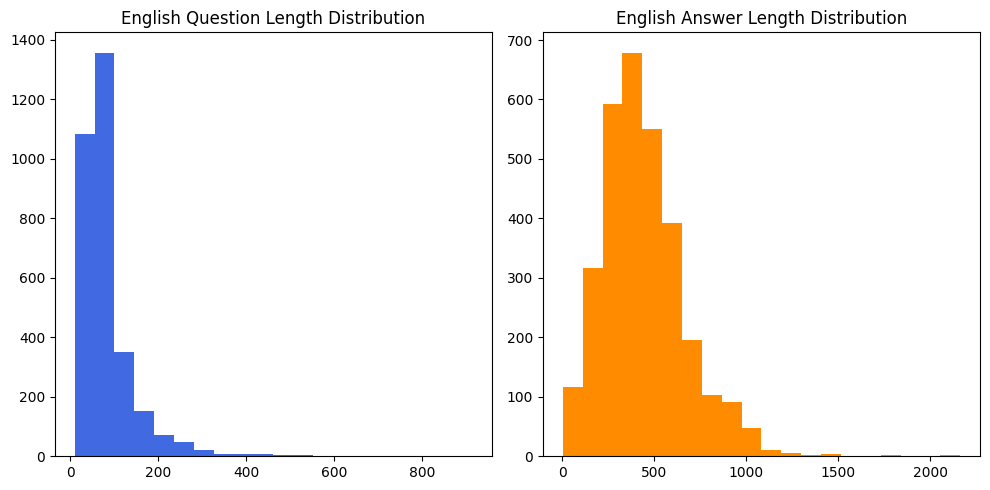

In [20]:
# Sample 10% of data to pandas for efficient histogram plotting
sample_pd = df_lengths.select("input_en_length", "output_en_length").sample(0.1, seed=42).toPandas()

plt.figure(figsize=(10,5))

# Plot histogram for English question lengths
plt.subplot(1,2,1)
plt.hist(sample_pd['input_en_length'].dropna(), bins=20, color='royalblue')
plt.title("English Question Length Distribution")

# Plot histogram for English answer lengths
plt.subplot(1,2,2)
plt.hist(sample_pd['output_en_length'].dropna(), bins=20, color='darkorange')
plt.title("English Answer Length Distribution")

plt.tight_layout()
plt.show()


In [21]:
# Count and report null or empty strings in input/output English texts
for col in ["input", "output"]:
    null_empty_count = df.filter(F.col(col).isNull() | (F.col(col) == "")).count()
    total_count = df.count()
    print(f"Null or empty count for '{col}': {null_empty_count} ({null_empty_count / total_count * 100:.2f}%)")


Null or empty count for 'input': 0 (0.00%)
Null or empty count for 'output': 0 (0.00%)


In [22]:
# Use Spark MLlib to compute Pearson correlation of question and answer lengths
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation

assembler = VectorAssembler(inputCols=["input_en_length", "output_en_length"], outputCol="features_en")
df_en = assembler.transform(df_lengths).select("features_en").na.drop()

corr_matrix_en = Correlation.corr(df_en, "features_en").head()[0]
corr_en = corr_matrix_en.toArray()

print(f"Correlation between English question and answer length: {corr_en[0, 1]:.4f}")


Correlation between English question and answer length: 0.0614


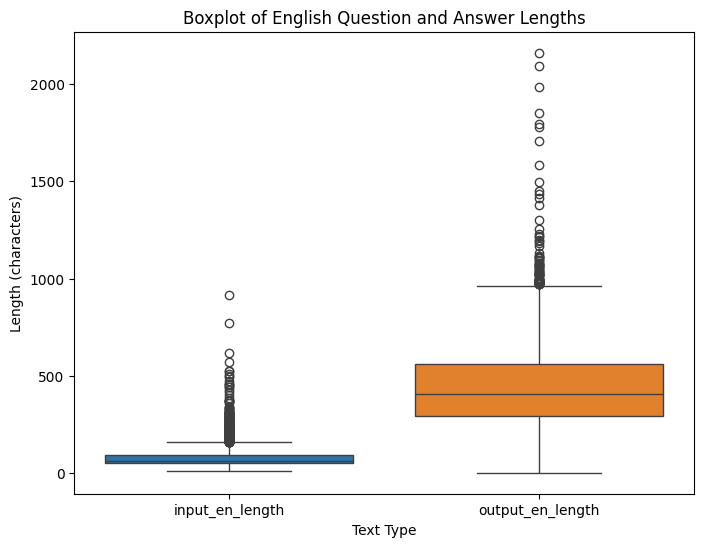

In [25]:
import seaborn as sns

# Use a sample for efficiency
sample_pd = df_lengths.select("input_en_length", "output_en_length").sample(0.1, seed=42).toPandas()

plt.figure(figsize=(8,6))
sns.boxplot(data=sample_pd)
plt.title("Boxplot of English Question and Answer Lengths")
plt.xlabel("Text Type")
plt.ylabel("Length (characters)")
plt.show()


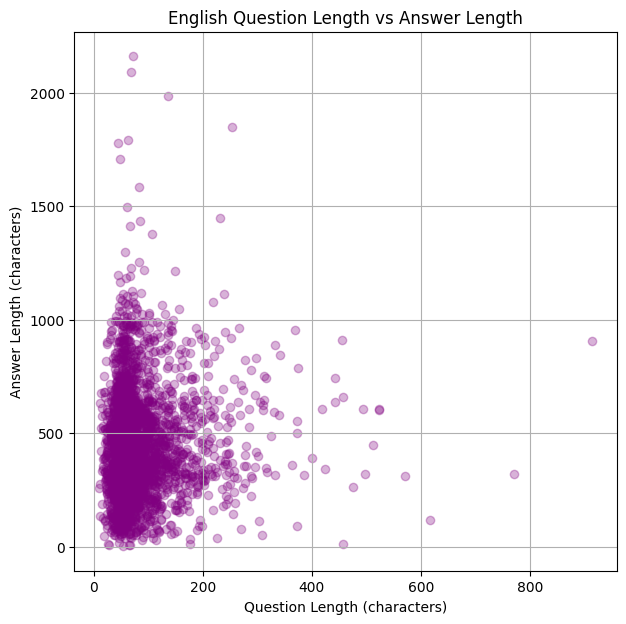

In [26]:
sample_scatter = df_lengths.select("input_en_length", "output_en_length").sample(0.1, seed=42).toPandas()

plt.figure(figsize=(7,7))
plt.scatter(sample_scatter['input_en_length'], sample_scatter['output_en_length'], alpha=0.3, color='purple')
plt.title("English Question Length vs Answer Length")
plt.xlabel("Question Length (characters)")
plt.ylabel("Answer Length (characters)")
plt.grid(True)
plt.show()


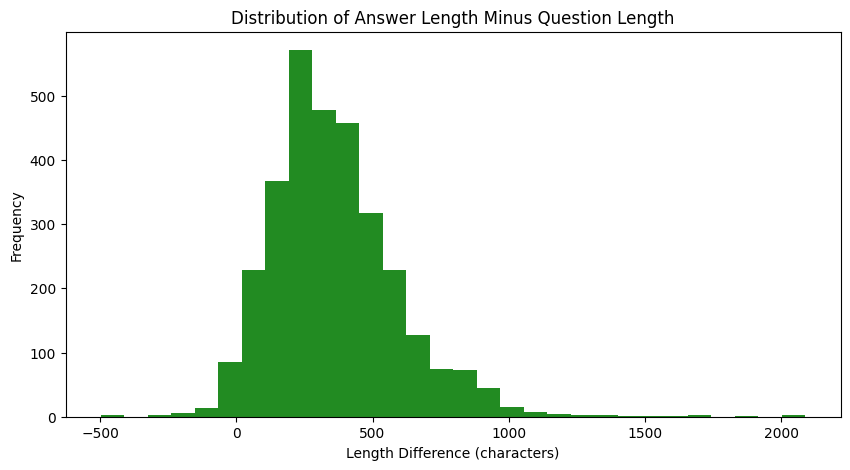

In [27]:
# Calculate difference column in pandas for plotting
sample_scatter['length_diff'] = sample_scatter['output_en_length'] - sample_scatter['input_en_length']

plt.figure(figsize=(10,5))
plt.hist(sample_scatter['length_diff'], bins=30, color='forestgreen')
plt.title("Distribution of Answer Length Minus Question Length")
plt.xlabel("Length Difference (characters)")
plt.ylabel("Frequency")
plt.show()


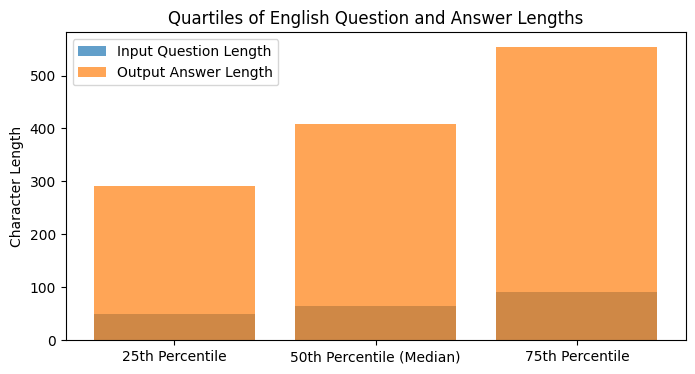

In [30]:
input_quartiles = df_lengths.approxQuantile("input_en_length", [0.25, 0.5, 0.75], 0.01)
output_quartiles = df_lengths.approxQuantile("output_en_length", [0.25, 0.5, 0.75], 0.01)

quartile_names = ['25th Percentile', '50th Percentile (Median)', '75th Percentile']

plt.figure(figsize=(8,4))

plt.bar(quartile_names, input_quartiles, alpha=0.7, label="Input Question Length")
plt.bar(quartile_names, output_quartiles, alpha=0.7, label="Output Answer Length")
plt.ylabel("Character Length")
plt.title("Quartiles of English Question and Answer Lengths")
plt.legend()
plt.show()


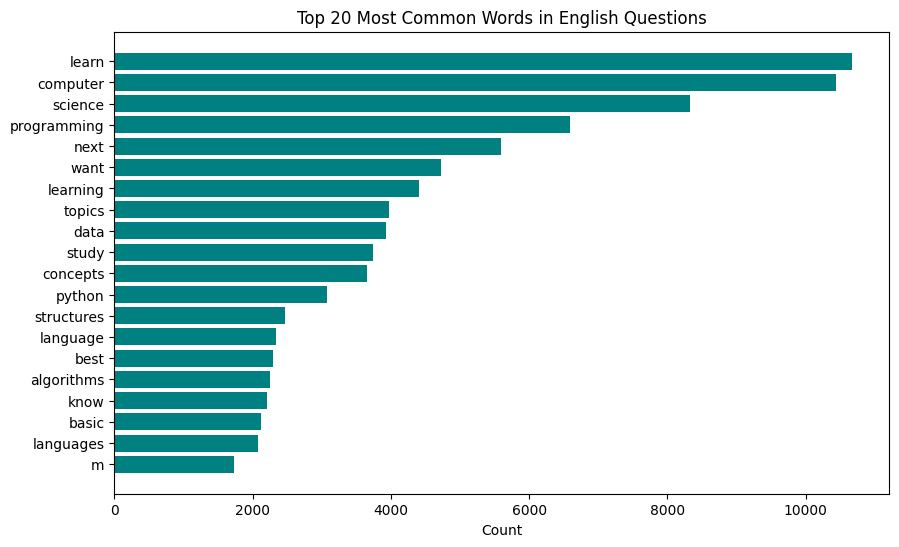

In [31]:
# Assuming top_words list from previous code is available

words = [w for w, c in top_words[:20]]
counts = [c for w, c in top_words[:20]]

plt.figure(figsize=(10,6))
plt.barh(words[::-1], counts[::-1], color='teal')
plt.xlabel('Count')
plt.title('Top 20 Most Common Words in English Questions')
plt.show()
